# Probabilistic Reconciliation via Conditioning with bayesreconpy

# Introduction

This notebook shows how to perform *probabilistic reconciliation* with the `bayesreconpy` package. It is the python version of the original vignette in R available [here](https://cran.r-project.org/web/packages/bayesRecon/vignettes/bayesRecon.html). We provide three examples:

1. *Temporal hierarchy for a count time series*: we build a temporal hierarchy over a count time series, import the base forecasts from R that used `glarma` and reconcile them via Bottom-Up Importance Sampling (BUIS).
2. *Temporal hierarchy for a smooth time series*: we build a temporal hierarchy over a smooth time series, import the base forecasts from R that used `ets` and we reconcile them in closed form using Gaussian reconciliation. The covariance matrix is diagonal.
3. *Hierarchical of smooth time series*: this is an example of a cross-sectional hierarchy. We obtain the base forecasts from R that used `ets` and we reconcile them via Gaussian reconciliation. The covariance matrix is full and estimated via shrinkage.

Note: We import the base forecasts instead of generating them to check the similarity in results in both; different packages in python and R might lead different base forecasts even with the same method, and we avoid it here since obtaining base forecast is not the main objective here.

# Installation

The package, available at [pip](https://pypi.org/project/bayesreconpy/), can be installed and loaded with the usual commands:
`pip install bayesreconpy`

Loading the package:

In [1]:
import bayesreconpy

We select a monthly time series of counts from the *carparts* dataset, available from the expsmooth package (R. J. Hyndman 2015). The data set contains time series of sales of cars part from Jan. 1998 to Mar. 2002. For this example we select time series #2655, which is available as `carparts_example.pkl`.

This time series has a skewed distribution of values.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from properscoring import crps_ensemble
from bayesreconpy.hierarchy import get_reconc_matrices, temporal_aggregation
from bayesreconpy.reconc_BUIS import reconc_BUIS
from bayesreconpy.reconc_gaussian import reconc_gaussian
from scipy.stats import norm

/tmp/ipykernel_102550/3570334295.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_index = pd.date_range(start="1998-01", periods=len(flat_data), freq="M")


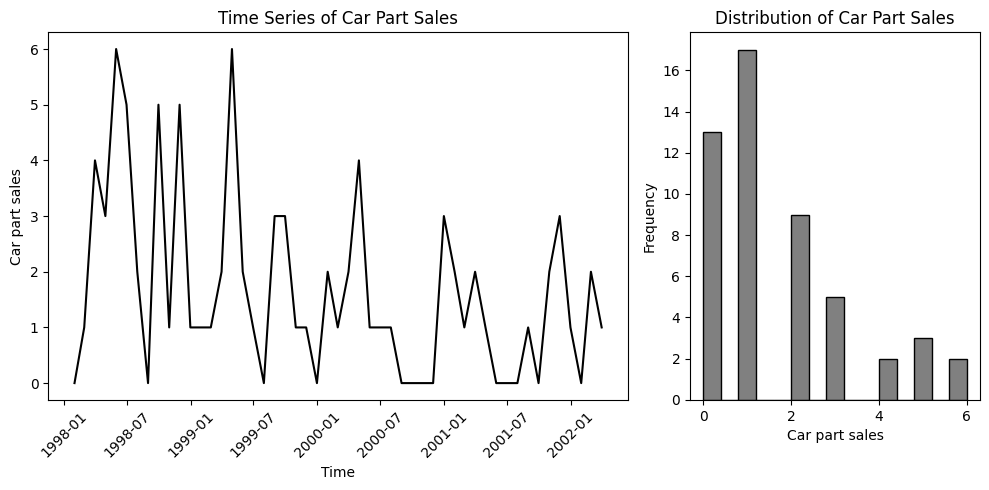

In [9]:
# Sample data (replace with your actual data)
carparts_example = pd.read_pickle('../data/carparts_example.pkl')

flat_data = carparts_example.values.flatten()
flat_data = flat_data[~np.isnan(flat_data)]  # Remove NaN values for plotting

# Generate a date range for the x-axis labels
# Start from "1998-01", with monthly frequency, matching the length of the data
date_index = pd.date_range(start="1998-01", periods=len(flat_data), freq="M")

# Create the layout: 1 row, 2 columns with custom widths
fig = plt.figure(figsize=(10, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])

# Time series plot in the first subplot with timestamps on x-axis
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(date_index, flat_data, color='black')  # Single line plot with timestamps
ax1.set_xlabel("Time")
ax1.set_ylabel("Car part sales")
ax1.set_title("Time Series of Car Part Sales")
ax1.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability

# Histogram in the second subplot
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(flat_data, bins=15, color='gray', edgecolor='black')
ax2.set_xlabel("Car part sales")
ax2.set_ylabel("Frequency")
ax2.set_title("Distribution of Car Part Sales")

plt.tight_layout()
plt.show()


We divide the time series into train and test; the test set contains the last 12 months.

In [10]:
carparts_example = carparts_example.stack()  # Convert to long format
carparts_example.index = pd.to_datetime(
    [f"{year}-{month}" for year, month in carparts_example.index], format="%Y-%b"
)

# Now split into train and test sets
train = carparts_example[:'2001-03']
test = carparts_example['2001-04':]

We build the temporal hierarchy using the temporal aggregation function. We specify the aggregation levels using the agg_levels argument; in this case they are 2-Monthly, Quarterly, 4-Monthly, Biannual, and Annual.

In [11]:
agg_levels = {
    "Annual": train.resample("A").sum(),      # Annual aggregation
    "Biannual": train.resample("6M").sum(),   # Biannual aggregation (every 6 months)
    "4-Monthly": train.resample("4M").sum(),  # Every 4 months
    "Quarterly": train.resample("Q").sum(),   # Quarterly aggregation
    "2-Monthly": train.resample("2M").sum(),  # Bi-monthly (every 2 months)
    "Monthly": train.resample("M").sum()      # Monthly aggregation
}

/tmp/ipykernel_102550/1495355138.py:2: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  "Annual": train.resample("A").sum(),      # Annual aggregation
/tmp/ipykernel_102550/1495355138.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "Biannual": train.resample("6M").sum(),   # Biannual aggregation (every 6 months)
/tmp/ipykernel_102550/1495355138.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "4-Monthly": train.resample("4M").sum(),  # Every 4 months
/tmp/ipykernel_102550/1495355138.py:5: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  "Quarterly": train.resample("Q").sum(),   # Quarterly aggregation
/tmp/ipykernel_102550/1495355138.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "2-Monthly": train.resample("2

The function returns a list of aggregated time series, ordered from the most aggregated (top of the hierarchy) to the most disagreggated (bottom of the hierarchy). We plot them below.

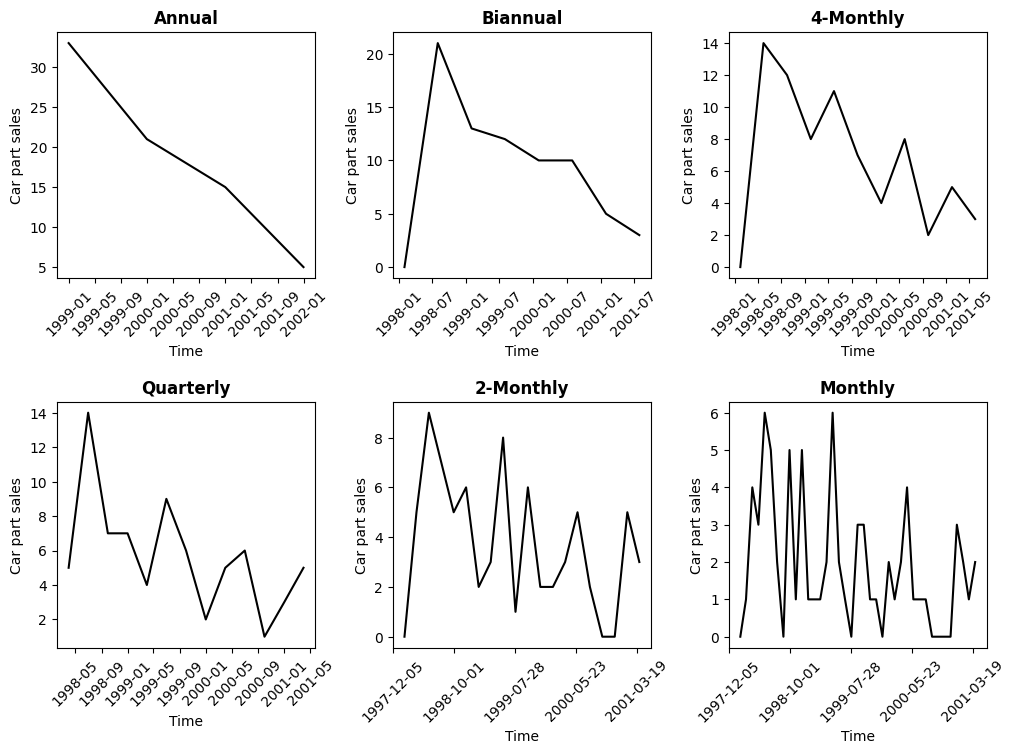

In [12]:
# Define the layout for the plots with adjusted spacing
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # 2 rows, 3 columns
fig.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust spacing between plots

# Plot each aggregated time series in its own subplot
for ax, (level, data) in zip(axes.flatten(), agg_levels.items()):
    ax.plot(data, color='black')  # Change line color to black for consistency
    ax.set_xlabel("Time")
    ax.set_ylabel("Car part sales")
    ax.set_title(level, fontsize=12, fontweight='bold')  # Increase title font size and weight
    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels if needed

    # Reduce the number of x-axis ticks for readability, if there are too many
    if level in ["Monthly", "2-Monthly"]:
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))  # Adjust number of ticks for readability

plt.show()

We import the base forecasts from `fc_samples.pkl` as fc_samples which were obtained in R using `glarma` .